#### Importation des librairies et initialisation des constantes

In [1]:
import numpy as np
import librosa
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import cmath

In [2]:
c = 340  # vitesse du son en m/s
L = 0.25  # distance entre les micros en mètres (25 cm)
Fs = 16000  # fréquence d'échantillonnage

#### Chargement des fichiers audios

In [3]:
chemin_fichiers = "raw_data/"
fichiers = ["48.flac", "2.flac", "78.flac"]

s1, _ = librosa.load(chemin_fichiers + fichiers[0], sr=Fs)
s2, _ = librosa.load(chemin_fichiers + fichiers[1], sr=Fs)
s3, _ = librosa.load(chemin_fichiers + fichiers[2], sr=Fs)

In [67]:
d_11 = 2 # Source 1 à Micro 1
d_21 = np.sqrt(d_11**2 - (L**2 / 2)) + (L / np.sqrt(2))  # Source 1 à Micro 2, calculée en fonction de d_11 et L
print(f"Distance source 1 avec micro 1 et 2 | d_11 : {d_11} ; d_21 : {d_21}")
d_12 = 2.2  # Source 2 à Micro 1 (d_12 = d_22 pour la Source 2)
d_22 = np.sqrt(d_12**2 + L**2)  # Source 2 à Micro 2
print(f"Distance source 2 avec micro 1 et 2 | d_12 : {d_12} ; d_22 : {d_22}")

# Pour la Source 3, nous supposons que la distance au Micro 2 est la même que d_11 à Micro 1
d_23 = 2 # Source 3 à Micro 2
d_13 = np.sqrt(d_23**2 - (L**2 / 2)) + (L / np.sqrt(2))  # Source 3 à Micro 1, calculée en fonction de d_23 et L
print(f"Distance source 3 avec micro 1 et 2 | d_23 : {d_23} ; d_13 : {d_13}")



# Calcul des gains et des retards
a_11 = 1/(np.sqrt(4*np.pi)*d_11)
a_12 = 1/(np.sqrt(4*np.pi)*d_12)
a_13 = 1/(np.sqrt(4*np.pi)*d_13)
a_21 = 1/(np.sqrt(4*np.pi)*d_21)
a_22 = 1/(np.sqrt(4*np.pi)*d_22)
a_23 = 1/(np.sqrt(4*np.pi)*d_23)

Distance source 1 avec micro 1 et 2 | d_11 : 2 ; d_21 : 2.1689488766102905
Distance source 2 avec micro 1 et 2 | d_12 : 2.2 ; d_22 : 2.214158982548453
Distance source 3 avec micro 1 et 2 | d_23 : 2 ; d_13 : 2.1689488766102905


#### Création des signaux sur les deux micros

In [68]:
def startOfDelay(distance):
    return int((distance/c) * Fs)

def soundDelayed(signal, distance):
    start = startOfDelay(distance)
    x_delayed = (np.zeros_like(signal))
    x_delayed[start:] = signal[:-start]
    return x_delayed

In [69]:
# Tout d'abord, il faut qu'ils aient la meme taille
len_max = max(len(s1), len(s2), len(s3))
s1 = np.pad(s1, (0, len_max - len(s1)))
s2 = np.pad(s2, (0, len_max - len(s2)))
s3 = np.pad(s3, (0, len_max - len(s3)))


# X1
x11_delayed = soundDelayed(s1, d_11)
x12_delayed = soundDelayed(s2, d_12)
x13_delayed = soundDelayed(s3, d_13)

x1 = a_11 * x11_delayed + a_12 * x12_delayed + a_13 * x13_delayed

# X2
x21_delayed = soundDelayed(s1, d_21)
x22_delayed = soundDelayed(s2, d_22)
x23_delayed = soundDelayed(s3, d_23)

x2 = a_21 * x21_delayed + a_22 * x22_delayed + a_23 * x23_delayed


In [70]:
display(Audio(x1, rate=Fs))
display(Audio(x2, rate=Fs))

#### Estimation des paramètres

In [71]:
n_fft=512
n_window=512
hop_length=256

X1 = librosa.stft(x1, n_fft=n_fft, hop_length=hop_length,win_length=n_window)
X2 = librosa.stft(x2, n_fft=n_fft, hop_length=hop_length,win_length=n_window)

ratio = X1 / X2
delay = X2.copy()
for k in range(X2.shape[0]):
        for m in range(X2.shape[1]):
            delay[k,m] = -n_window / (2*np.pi*(k+1)) * cmath.phase(ratio[k,m])


delayed = np.real(delay)
attenuation = np.abs(ratio)



Text(0.5, 1.0, 'How to plot a 2d histogram with matplotlib ?')

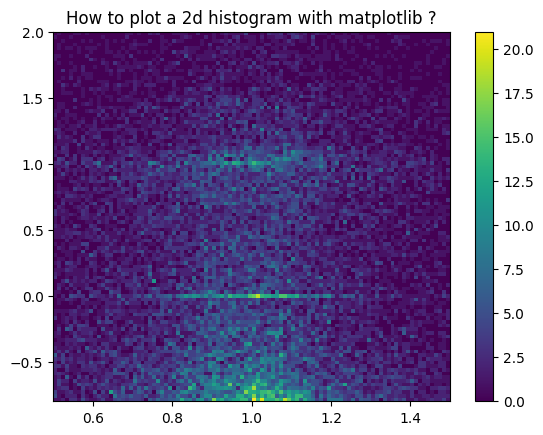

In [72]:
fig2=plt.figure(2)
plt.hist2d(attenuation.flatten(),delayed.flatten(),bins=(100,100),range=[[0.5, 1.5],[-0.80, 2]])
plt.colorbar()
plt.title("How to plot a 2d histogram with matplotlib ?")

Nous pouvons voir trois sources, mais si nous affichons complètement celle en bas, nous ne verrions que elle car ses valeurs sont énormes par rapport aux autres.

#### Calcul des masks

In [73]:
def distance(x1,x2,y1,y2):
    return np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

a=[-1, 0, 1]
d=[1, 1, 1]
mask_1=np.zeros_like(attenuation)
mask_2=np.zeros_like(attenuation)
mask_3=np.zeros_like(attenuation)

for k in range(attenuation.shape[0]):
      for m in range(attenuation.shape[1]):
         d1=distance(attenuation[k,m],a[0],delayed[k,m],d[0])
         d2=distance(attenuation[k,m],a[1],delayed[k,m],d[1])
         d3=distance(attenuation[k,m],a[2],delayed[k,m],d[2])
         
         minimum=np.min((d1, d2, d3))
         if minimum == d1:
            mask_1[k,m] = 1
         elif minimum == d2:
            mask_2[k,m] = 1
         else:
            mask_3[k,m] = 1


x_filtered_1 = mask_1 * X1
x_filtered_2 = mask_2 * X1
x_filtered_3 = mask_3 * X1

unnoised_signal_1 = librosa.istft(x_filtered_1, n_fft = n_fft, hop_length = hop_length, win_length = n_window)
unnoised_signal_2 = librosa.istft(x_filtered_2, n_fft = n_fft, hop_length = hop_length, win_length = n_window)
unnoised_signal_3 = librosa.istft(x_filtered_3, n_fft = n_fft, hop_length = hop_length, win_length = n_window)

Nous avons écouté les signaux mais ce n'est pas bon du tout.

Malgré nos efforts, en séance et après, nous n'avons pas réussi à obtenir de bon résultats. Nous supposons que notre erreur proviendrai de la partie estimation des deux signaux.